## Denoising Diffusion Probabilistic Models


This notebook is a minimalistic implementation of the [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) paper.  The paper has been used to great effect for generating realistic images while also avoiding the mode collapse problems often seen in GANs.  To keep things simple we will be using the MNIST dataset. The method involves training a CNN to predict the noise component in a partially corrupted image.  At inference time we apply this CNN to pure white noise, the predicted noise component is subtracted from the input and the result is feed into the network again.  We repeat this for a large number of steps (1000 in this notebook) to generate a new image modelled after the training data. The CNN architecure is somewhat arbitrary, but following the paper we will use a modified version of U-Net.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import torch
from torch import nn
import math
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

## Model

We use a U-Net like model with attention added and the time step embedded in each layer.

In [2]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 3, 1, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)  
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  50252001


## Data




First we download and plot the training data.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



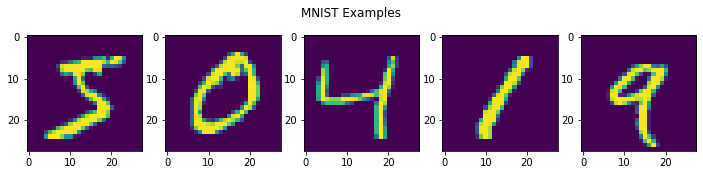

In [3]:
# Are we using the CPU or the GPU?
device = "cuda" if torch.cuda.is_available() else "cpu"

# Transforms to be applied to all images in the dataset
tf = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))]
)

# Download/setup the MNIST dataset
dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

# Plot examples
fig, ax= plt.subplots(1, 5, figsize=(12, 2.5))
fig.suptitle('MNIST Examples')
ax[0].imshow(dataset[0][0][0,:,:].numpy())
ax[1].imshow(dataset[1][0][0,:,:].numpy())
ax[2].imshow(dataset[2][0][0,:,:].numpy())
ax[3].imshow(dataset[3][0][0,:,:].numpy())
ax[4].imshow(dataset[4][0][0,:,:].numpy())


How do we add noise to these MNIST images?  Over $T=1000$ time steps $t$, we gradually add Gaussian noise. We call this the forward process and model it using $q(x_t|x_{t-1})$ where $x_t$ is an image at time step $t$.  So at time $x_0$ we have an MNIST image uncorrupted by noise, at $x_{483}$ we have an MNIST image that is mixed with noise, and at $x_{1000}$ we have pure noise.

To add this noise we will use a linear schedule controlled by parameter $\beta=0.0001...0.02$

$$ q(x_t|x_{t-1})=\mathcal{N}(\sqrt{1-\beta_t}x_{t-1}, \beta_t\boldsymbol{I})$$

However, we have a problem.  To calculate $x_{1000}$ would would need to apply this formular recursivly 1000 times!  So to simplify this we can rewrite it as

$$ q(x_t|x_0)=\mathcal{N}(\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})\boldsymbol{I})$$

where
$$\alpha_t=1-\beta_t$$
$$\bar{\alpha_t}=\prod_{s=1}^t{\alpha_s}$$

These values are computed below and will be very important during both training sampling.


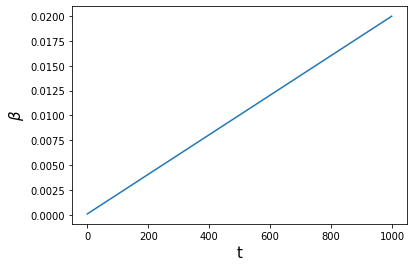

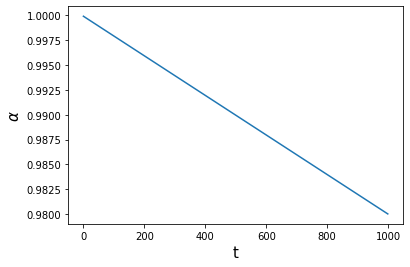

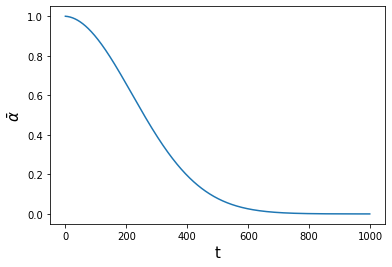

In [4]:
# Number of time steps
T=1000

# One beta values for each time step, they linearly scale from 0.0001 to 0.2
betas = np.zeros(T)
lowest = 0.0001 
highest = 0.02 
step = (highest - lowest) / T
for i in range(T):
  betas[i] = (lowest + i * step)

# Calculate alpha values, then cumulative alpha values, then the square roots of the alpha
alphas = 1 - betas
alphas_cum = np.cumprod(alphas)
sqrt_alpha = np.sqrt(alphas_cum)
sqrt_1_minus_alpha = np.sqrt(1 - alphas_cum)

# Convert to pytorch tensors
sqrt_alpha = torch.from_numpy(sqrt_alpha)
sqrt_1_minus_alpha = torch.from_numpy(sqrt_1_minus_alpha)
sqrt_alpha = sqrt_alpha.to(device)
sqrt_1_minus_alpha = sqrt_1_minus_alpha.to(device)

# Plot beta
plt.figure().gca().set_ylabel(r'$\beta$', fontsize=15)
plt.plot(betas)
plt.xlabel('t', fontsize=15)
plt.show()

# Plot alpha
plt.figure().gca().set_ylabel(r'$\alpha$', fontsize=15)
plt.plot(alphas)
plt.xlabel('t', fontsize=15)
plt.show()

# Plot alpha bar
plt.figure().gca().set_ylabel(r'$\bar{\alpha}$', fontsize=15)
plt.plot(alphas_cum)
plt.xlabel('t', fontsize=15)
plt.show()


## Training



The block of code below sets up hyperparameters, a dataloader and an Adam optimizer.  It then executes the following algorithm. In order to train our denoising CNN, we execute the following simple algorithm where $ϵ_{\theta}$ is our neural network. 

1. $~~\text{repeat}$
2. $~~~~~~x_0 \sim q(x_0)$
3. $~~~~~~t \sim \text{Uniform}(\{1...T\})$
4. $~~~~~~ϵ \sim \mathcal{N}(0,I)$
5. $~~~~~~\text{taking gradient descent step on}$
6. $~~~~~~~~~~~∇_{θ}||ϵ-ϵ_{\theta}(\bar{\alpha_t}x_0+\sqrt{1-\bar{\alpha_t}}ϵ, t)||$
7. $~~~~~~\text{until convergence}$


In [5]:
# Send model to GPU (or CPU)
model = SimpleUnet()
model.to(device)

# Define hyperparameters
epochs = 25
learning_rate = 2e-4

# Define loss function
mse_loss = nn.MSELoss()
mse_loss = mse_loss.to(device)

# Define dataset
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=20)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loss_history = []
for e in range(epochs):
  total_loss = 0
  pbar = tqdm(dataloader)

  for x, _ in pbar:
    x = x.to(device)
    _ts = torch.randint(1, T, (x.shape[0],)).to(x.device) 
    noise = torch.randn_like(x).to(x.device)

    # Blend noise an image
    x_t = (
        sqrt_alpha[_ts, None, None, None].to(x.device) * x
        + sqrt_1_minus_alpha[_ts, None, None, None].to(x.device) * noise
    )  

    # Forward pass
    denoised_img = model(x_t.float(), _ts.float())
    loss = mse_loss(noise.float(), denoised_img)
    total_loss = total_loss + loss.item()

    # Backwards pass
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  print("Epoch {}: Total Loss {}".format(e,total_loss))
  loss_history.append(total_loss)
  torch.save(model.state_dict(), 'checkpoint.pth')



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 469/469 [22:58<00:00,  2.94s/it]


Epoch 0: Total Loss 25.439624324440956


100%|██████████| 469/469 [23:20<00:00,  2.99s/it]


Epoch 1: Total Loss 14.270950129255652


100%|██████████| 469/469 [23:12<00:00,  2.97s/it]


Epoch 2: Total Loss 12.996341984719038


100%|██████████| 469/469 [23:07<00:00,  2.96s/it]


Epoch 3: Total Loss 12.407587472349405


100%|██████████| 469/469 [23:04<00:00,  2.95s/it]


Epoch 4: Total Loss 12.117709826678038


100%|██████████| 469/469 [23:00<00:00,  2.94s/it]


Epoch 5: Total Loss 11.669056937098503


100%|██████████| 469/469 [22:59<00:00,  2.94s/it]


Epoch 6: Total Loss 11.497911592945457


100%|██████████| 469/469 [23:00<00:00,  2.94s/it]


Epoch 7: Total Loss 11.400461988523602


100%|██████████| 469/469 [22:58<00:00,  2.94s/it]


Epoch 8: Total Loss 11.405342780053616


100%|██████████| 469/469 [22:55<00:00,  2.93s/it]


Epoch 9: Total Loss 11.192386383190751


100%|██████████| 469/469 [22:54<00:00,  2.93s/it]


Epoch 10: Total Loss 11.091774810105562


100%|██████████| 469/469 [22:54<00:00,  2.93s/it]


Epoch 11: Total Loss 11.060233442112803


100%|██████████| 469/469 [22:52<00:00,  2.93s/it]


Epoch 12: Total Loss 10.953648621216416


100%|██████████| 469/469 [22:50<00:00,  2.92s/it]


Epoch 13: Total Loss 10.991118947044015


100%|██████████| 469/469 [22:48<00:00,  2.92s/it]


Epoch 14: Total Loss 10.766507089138031


100%|██████████| 469/469 [22:45<00:00,  2.91s/it]


Epoch 15: Total Loss 10.731948931701481


100%|██████████| 469/469 [22:44<00:00,  2.91s/it]


Epoch 16: Total Loss 10.701974898576736


100%|██████████| 469/469 [22:43<00:00,  2.91s/it]


Epoch 17: Total Loss 10.503723341040313


100%|██████████| 469/469 [22:42<00:00,  2.91s/it]


Epoch 18: Total Loss 10.786981189623475


100%|██████████| 469/469 [22:43<00:00,  2.91s/it]


Epoch 19: Total Loss 10.55828664638102


100%|██████████| 469/469 [22:43<00:00,  2.91s/it]


Epoch 20: Total Loss 10.45151394419372


100%|██████████| 469/469 [22:43<00:00,  2.91s/it]


Epoch 21: Total Loss 10.53853770531714


100%|██████████| 469/469 [22:44<00:00,  2.91s/it]


Epoch 22: Total Loss 10.41091857291758


100%|██████████| 469/469 [22:43<00:00,  2.91s/it]


Epoch 23: Total Loss 10.450715139508247


100%|██████████| 469/469 [22:42<00:00,  2.91s/it]


Epoch 24: Total Loss 10.347982773557305


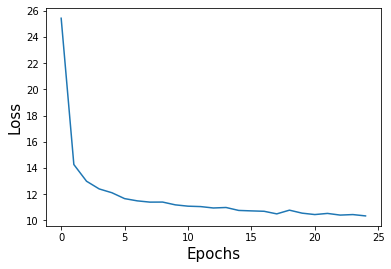

In [6]:
plt.plot(loss_history)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.show()

## Sampling

Here we sample (or generate) a batch of 64 images.  This can be done using the following algorithm

1. $~~x_T \sim \mathcal{N}(0,I)$
2. $~~\text{for}~t=1...T~\text{do}$
3. $~~~~~~z \sim \mathcal{N}(0,I) ~\text{if}~ t > 1, ~\text{else}~ z= 0$
4. $~~~~~~x_{t-1}=\frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1-\alpha_t}{\sqrt{1-\alpha_t}} ϵ_{\theta}(x_t,t)\right) + σ_tz$
5. $~~\text{end for}$
6. $~~\text{return}~x_0$

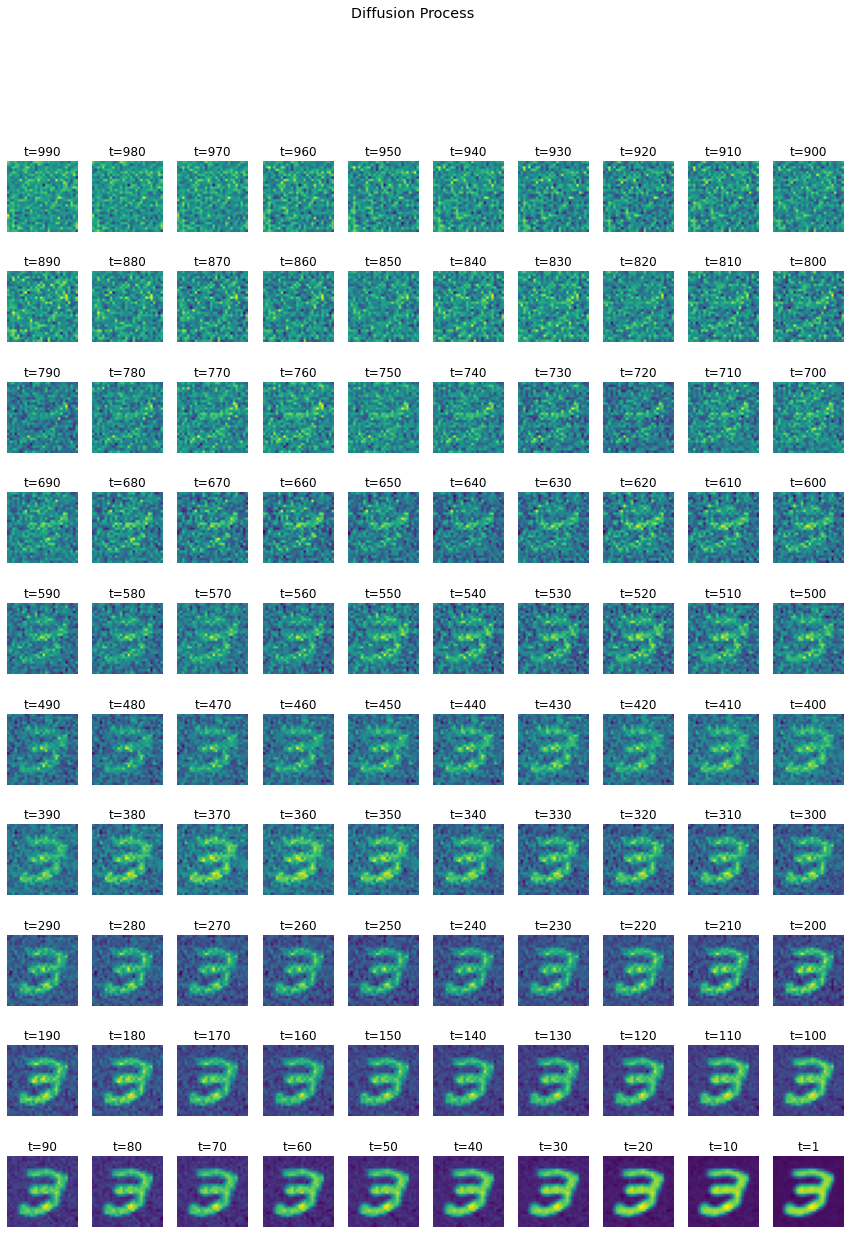

In [13]:
# Get inital noise
batch_size = 64
noise = torch.randn(batch_size,1,28,28)
noise = noise.to(device)

# Initalize plots 
fig, axs = plt.subplots(10, 10, figsize=(15,20))
fig.suptitle("Diffusion Process", fontsize="x-large")


# Inital run of the model
img = model(noise.float(), (torch.ones(batch_size, device=device) * 1000).float())

# Loop over the 1000 time steps
for i in range(999, 0, -1):

  # Get random noise (final step uses just zeros, no noise)
  if i > 1:
    noise = torch.randn_like(noise)
  else:
    noise = torch.zeros_like(noise)

  # Move images from CPU to GPU to prevent the graph from getting too large.
  # This prevents memory overflowing (TODO: do a nicer implement this bit)
  img = img.detach()
  img = img.to(device)
  noise = noise.to(device)

  # Get this time steps parameters
  sigma_t = betas[i]
  alpha = alphas[i]
  alpha_cum = alphas_cum[i]

  # Run noise prediction model and subtract it from the image
  img = (1 / np.sqrt(alpha)) * (img - ((1-alpha)/np.sqrt(1-alpha_cum)) * model(img.float(), (torch.ones(64, device=device) * i).float())) + np.sqrt(sigma_t) * noise

  # Move image CPU to remove gradient information
  img = img.to("cpu")
  noise = noise.to("cpu")

  # Plot every 10th image
  if i % 10 == 0 or i == 1:
    img_copy = img.clone().detach()
    img_copy = img_copy.numpy()
    img_copy = np.transpose(img_copy, (2,3,1,0))
    img_copy = img_copy - np.min(img_copy)
    img_copy = img_copy / np.max(img_copy)
    img_idx = 99 - int(i / 10)
    axs[int(img_idx / 10), int(img_idx % 10)].imshow(img_copy[:,:,0,0])
    axs[int(img_idx / 10), int(img_idx % 10)].axis('off')
    axs[int(img_idx / 10), int(img_idx % 10)].set_title('t='+str(i))

 

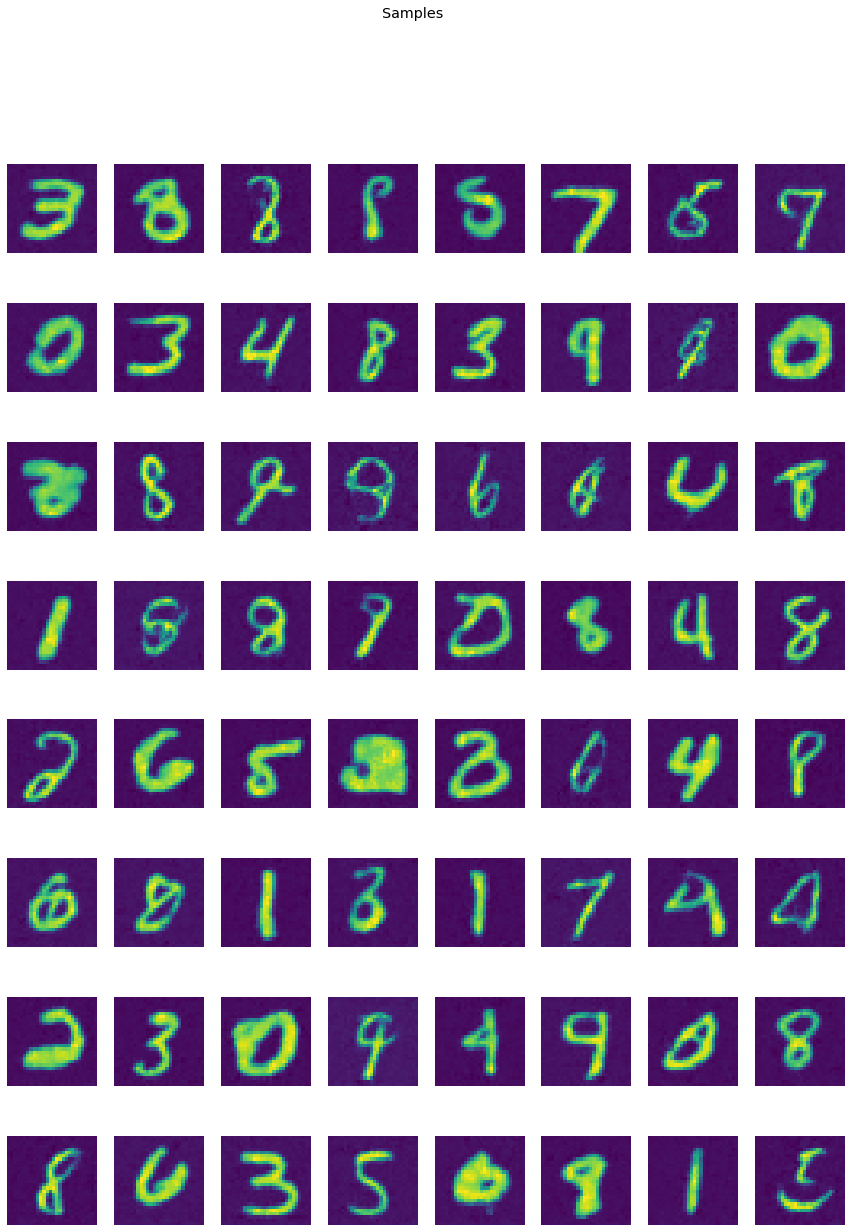

In [14]:
# Normalize image results
img_copy = img.clone().detach()
img_copy = img_copy.cpu().numpy()
img_copy = np.transpose(img_copy, (2,3,1,0))
img_copy = img_copy - np.min(img_copy)
img_copy = img_copy / np.max(img_copy)

# Initalize plots 
fig, axs = plt.subplots(8, 8, figsize=(15,20))
fig.suptitle("Samples", fontsize="x-large")

# Plot all images in the batch
for i in range(batch_size):
  axs[int(i / 8), int(i % 8)].imshow(img_copy[:,:,0,i])
  axs[int(i / 8), int(i % 8)].axis('off')



## Appendix

[This video](https://www.youtube.com/watch?v=HoKDTa5jHvg&t=946s) has a very good section about the maths derivations in this paper.






### Reverse Process

The forward process was mentioned in the **Data** section, but we also have the reverse process $p_{\theta}(x_{0:T})$ which can be thought of as a Markov chain. This is defined as

$$ p_{\theta}(x_{0:T}) = p_{\theta}(x_{T})∏_{t=1}^T{p_{\theta}(x_{t-1}|x_{t})} $$

where

$$ p_{\theta}(x_{T}) = \mathcal{N}(0,I)$$
$$ p_{\theta}(x_{t-1}|x_{t}) = \mathcal{N}(\mu_{\theta}(x_t,t), \Sigma_{\theta}(x_t,t))$$

Our functions $\mu_{\theta}$ and $\Sigma_{\theta}$ calculate the mean and variance of the normal distribution respectivly.  Because of our noise schedule the variance function is simply $\Sigma_{\theta}(x_t,t)=\beta_tI$.  Our mean function $\mu_{\theta}(x_t,t)$ is approximated using a neural network.  This is the neural network we trained in the above sections.  



### Loss Function
To optimise the neural network described above we need to minimize negative log likelihood

$$ -\text{log}(p_{\theta}(x_0)) $$

However, this value is not easily computable so we optimise a variational lower bound instead. This variation lower bound is created by adding the KL divergence $D_{KL}$, which measures the similarity between two distributions and is always positive.

$$ -\text{log}(p_{\theta}(x_0)) \le -\text{log}(p_{\theta}(x_0)) + D_{KL}(q(x_{1:T}|x_0)||p_{\theta}(x_{1:T}|x_0)) = L_{VLB}$$

which, after a lot of algebra, can be reformulated as

$$ L_{VLB} = D_{KL}(q(x_{T}|x_0)||p(x_{T})) + \sum_{t \ge 1} {D_{KL}(q(x_{t-1}|x_t,x_0)||p_{\theta}(x_{t-1}|x_t))-\text{log}p_{\theta}(x_0|x_1)} $$

The first term here is the KL divergence between two similar normal distributions, meaning it will be very small and can therefore be ignored

$$ L_{VLB} = \sum_{t \ge 1} {D_{KL}(q(x_{t-1}|x_t,x_0)||p_{\theta}(x_{t-1}|x_t))-\text{log}p_{\theta}(x_0|x_1)} $$

To both simplify the maths and improve sample quality, the authors changed this into our final simplified loss function

$$ L_{simple} = \left|\left| ϵ - \epsilon_{\theta}\left(\sqrt{\bar{\alpha_t}}x_0+\sqrt{1-\bar{\alpha_t}} ϵ ,t\right) \right|\right|^2 $$

where

$ ~~~~~~~~~~~~ t=$ time step

$ ~~~~~~~~~~~~ ϵ = $ noise

$ ~~~~~~~~~~~~ ϵ_{\theta} = $ neural network

$ ~~~~~~~~~~~~ \bar{\alpha_t}=$  (see **Data** section)

$ ~~~~~~~~~~~~ x_0=$ uncorrupted image


